In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import fit_library
sys.path.append("../PETALO_DAQ_infinity/SimLib")
import config_sim as CFG
import csv
%matplotlib nbagg
%load_ext autoreload
%autoreload 2

{u'ENVIRONMENT': {u'path_to_files': u'/home/viherbos/DAQ_DATA/NEUTRINOS/PETit-ring/4mm_pitch/', u'n_files': 12, u'file_name': u'p_FR_oneface_', u'time_bin': 5, u'MC_file_name': u'full_ring_iradius15cm_depth3cm_pitch4mm_one_face', u'out_file_name': u'DAQ_OUT_oneface', u'temperature': 300, u'n_events': 30000, u'MC_out_file_name': u'DAQ_OUT_oneface', u'ch_rate': 7100000.0}, u'SIPM': {u'size': [1, 3, 3]}, u'TOPOLOGY': {u'radius_ext': 180, u'n_rows': 16, u'sipm_ext_row': 282, u'radius_int': 150, u'sipm_int_row': 0}, u'TOFPET': {u'TGAIN': 1, u'TE': 2, u'outlink_rate': 16250000.0, u'OUT_FIFO_depth': 256, u'n_channels': 64, u'IN_FIFO_depth': 4, u'MAX_WILKINSON_LATENCY': 5120}, u'L1': {u'L1_mapping_O': [8, 8, 8, 8, 8, 8, 8, 8, 7], u'frame_process': 1500000.0, u'L1_mapping_I': [], u'L1_outrate': 700000000.0, u'n_asics': 9, u'map_style': u'striped_3', u'FIFO_L1b_depth': 128, u'FIFO_L1a_depth': 8192, u'buffer_size': 2048, u'TE': 4}}
[[ 0.  0.  0.  0.]]
LOST DATA PRODUCER -> CH      = 0
LOST DATA C

<IPython.core.display.Javascript object>


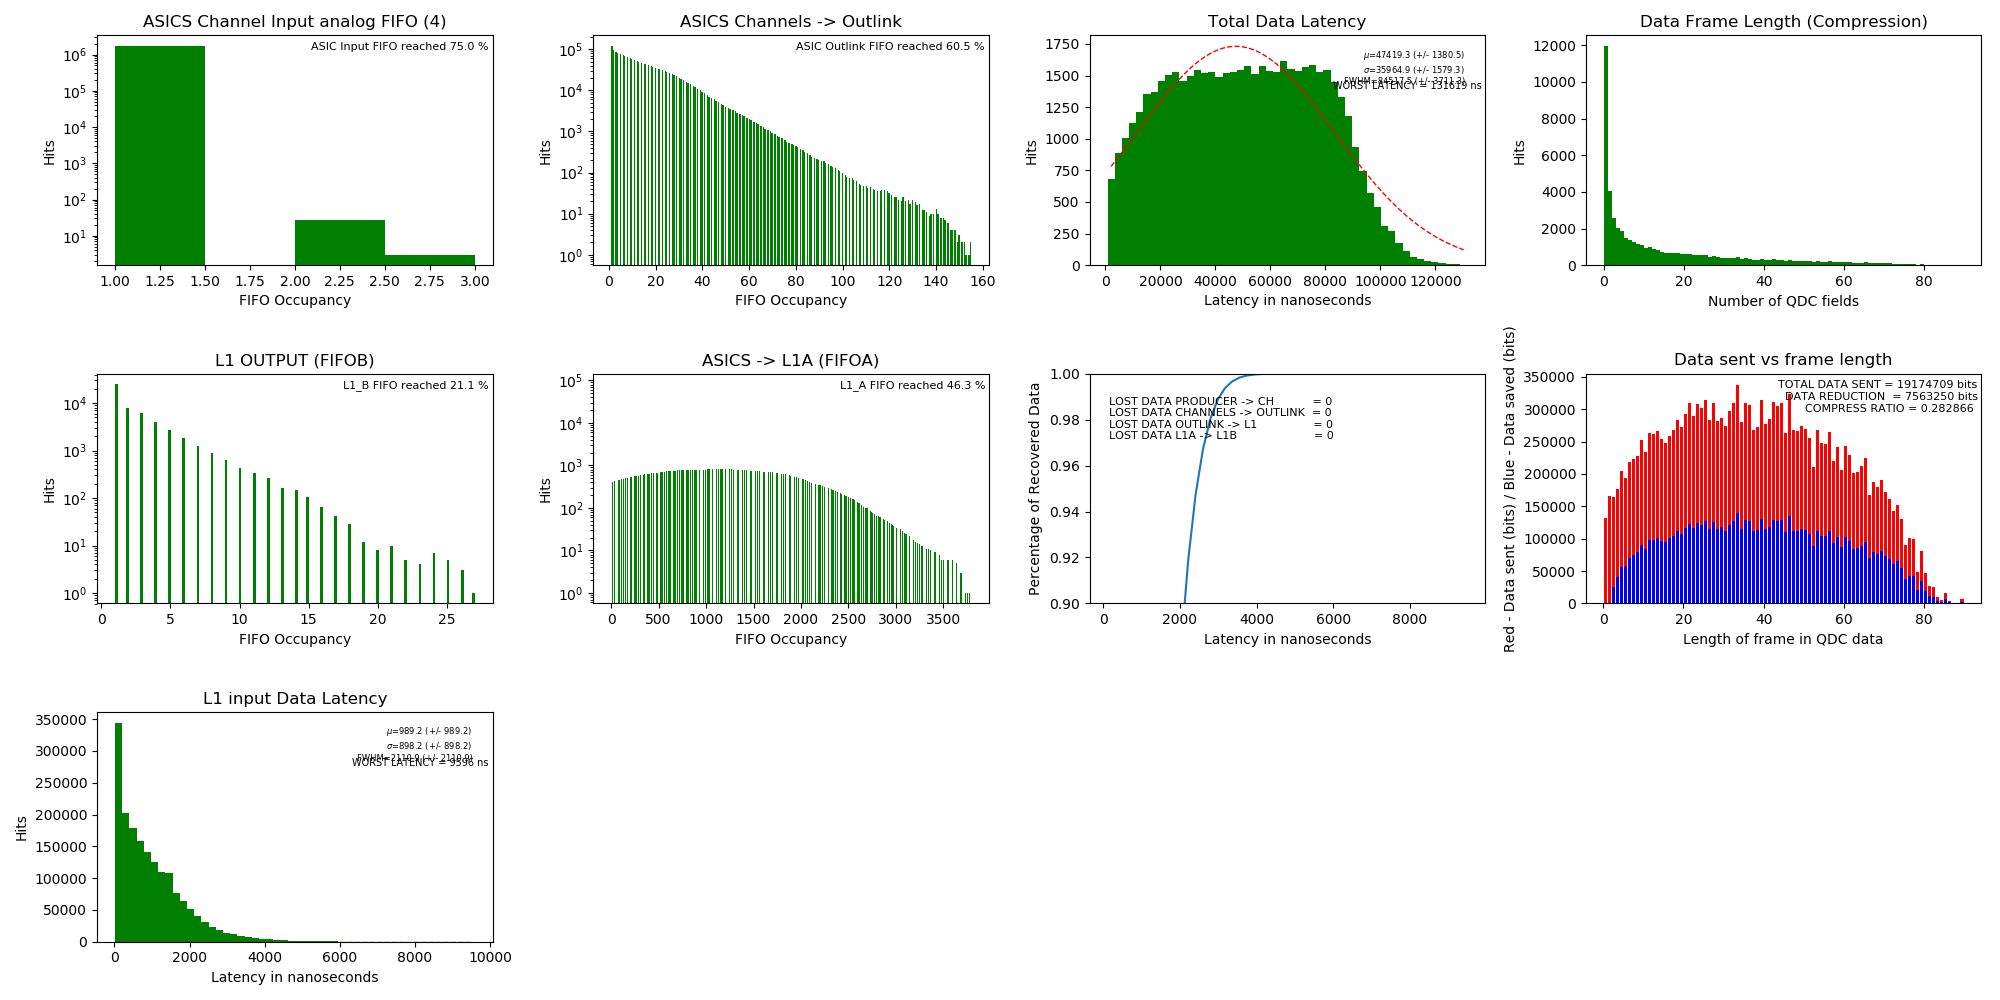

Fitting Problems
Fitting Problems
Fitting Problems
Fitting Problems
90.0


In [15]:
config_file = ["OF_4mm_min"]
data_path = "/home/viherbos/DAQ_DATA/NEUTRINOS/PETit-ring/4mm_pitch/"


for i in config_file:

    config_file2 = data_path + i + ".json"
    CG = CFG.SIM_DATA(filename = config_file2,read = True)
    CG = CG.data
    filename = CG['ENVIRONMENT']['out_file_name']+"_"+ i + ".h5"
    filename = data_path + filename

    logA         = np.array(pd.read_hdf(filename,key='logA'))
    logB         = np.array(pd.read_hdf(filename,key='logB'))
    log_channels = np.array(pd.read_hdf(filename,key='log_channels'))
    log_outlink  = np.array(pd.read_hdf(filename,key='log_outlink'))
    in_time      = np.array(pd.read_hdf(filename,key='in_time'))
    out_time     = np.array(pd.read_hdf(filename,key='out_time'))
    lost         = np.array(pd.read_hdf(filename,key='lost'))
    compress     = np.array(pd.read_hdf(filename,key='compress'))

    print lost
    
    latency_L1 = logA[:,1]
    latency    = out_time-in_time

    print ("LOST DATA PRODUCER -> CH      = %d" % (lost[:,0].sum()))
    print ("LOST DATA CHANNELS -> OUTLINK = %d" % (lost[:,1].sum()))
    print ("LOST DATA OUTLINK  -> L1      = %d" % (lost[:,2].sum()))
    print ("LOST DATA L1A -> L1B          = %d" % (lost[:,3].sum()))

    WC_CH_FIFO    = float(max(log_channels[:,0])/CG['TOFPET']['IN_FIFO_depth'])*100
    WC_OLINK_FIFO = float(max(log_outlink[:,0])/CG['TOFPET']['OUT_FIFO_depth'])*100
    WC_L1_A_FIFO  = float(max(logA[:,0])/CG['L1']['FIFO_L1a_depth'])*100
    WC_L1_B_FIFO  = float(max(logB[:,0])/CG['L1']['FIFO_L1b_depth'])*100


    print ("\n \n BYE \n \n")

    fit = fit_library.gauss_fit()
    fig = plt.figure(figsize=(20,10))

    fit(log_channels[:,0],CG['TOFPET']['IN_FIFO_depth'])
    fit.plot(axis = fig.add_subplot(341),
            title = "ASICS Channel Input analog FIFO (4)",
            xlabel = "FIFO Occupancy",
            ylabel = "Hits",
            res = False, fit = False)
    fig.add_subplot(341).set_yscale('log')
    fig.add_subplot(341).text(0.99,0.97,(("ASIC Input FIFO reached %.1f %%" % \
                                            (WC_CH_FIFO))),
                                            fontsize=8,
                                            verticalalignment='top',
                                            horizontalalignment='right',
                                            transform=fig.add_subplot(341).transAxes)

    fit(log_outlink[:,0],CG['TOFPET']['OUT_FIFO_depth'])
    fit.plot(axis = fig.add_subplot(342),
            title = "ASICS Channels -> Outlink",
            xlabel = "FIFO Occupancy",
            ylabel = "Hits",
            res = False, fit = False)
    fig.add_subplot(342).set_yscale('log')
    fig.add_subplot(342).text(0.99,0.97,(("ASIC Outlink FIFO reached %.1f %%" % \
                                            (WC_OLINK_FIFO))),
                                            fontsize=8,
                                            verticalalignment='top',
                                            horizontalalignment='right',
                                            transform=fig.add_subplot(342).transAxes)

    fit(logA[:,0],CG['L1']['FIFO_L1a_depth'])
    fit.plot(axis = fig.add_subplot(346),
            title = "ASICS -> L1A (FIFOA)",
            xlabel = "FIFO Occupancy",
            ylabel = "Hits",
            res = False, fit = False)
    fig.add_subplot(346).set_yscale('log')
    fig.add_subplot(346).text(0.99,0.97,(("L1_A FIFO reached %.1f %%" % \
                                            (WC_L1_A_FIFO))),
                                            fontsize=8,
                                            verticalalignment='top',
                                            horizontalalignment='right',
                                            transform=fig.add_subplot(346).transAxes)

    fit(logB[:,0],CG['L1']['FIFO_L1b_depth'])
    fit.plot(axis = fig.add_subplot(345),
            title = "L1 OUTPUT (FIFOB)",
            xlabel = "FIFO Occupancy",
            ylabel = "Hits",
            res = False, fit = False)
    fig.add_subplot(345).set_yscale('log')
    fig.add_subplot(345).text(0.99,0.97,(("L1_B FIFO reached %.1f %%" % \
                                            (WC_L1_B_FIFO))),
                                            fontsize=8,
                                            verticalalignment='top',
                                            horizontalalignment='right',
                                            transform=fig.add_subplot(345).transAxes)
    fit(latency,50)
    fit.plot(axis = fig.add_subplot(343),
            title = "Total Data Latency",
            xlabel = "Latency in nanoseconds",
            ylabel = "Hits",
            res = False)
    fig.add_subplot(343).text(0.99,0.8,(("WORST LATENCY = %d ns" % \
                                            (max(latency)))),
                                            fontsize=7,
                                            verticalalignment='top',
                                            horizontalalignment='right',
                                            transform=fig.add_subplot(343).transAxes)

    fit(latency_L1,50)
    fit.plot(axis = fig.add_subplot(349),
            title = "L1 input Data Latency",
            xlabel = "Latency in nanoseconds",
            ylabel = "Hits",
            res = False)
    fig.add_subplot(349).text(0.99,0.8,(("WORST LATENCY = %d ns" % \
                                            (max(latency_L1)))),
                                            fontsize=7,
                                            verticalalignment='top',
                                            horizontalalignment='right',
                                            transform=fig.add_subplot(349).transAxes)

    new_axis = fig.add_subplot(347)
    x_data = fit.bin_centers
    y_data = np.add.accumulate(fit.hist_fit)/np.max(np.add.accumulate(fit.hist_fit))
    new_axis.plot(x_data,y_data)
    new_axis.set_ylim((0.9,1.0))
    new_axis.set_xlabel("Latency in nanoseconds")
    new_axis.set_ylabel("Percentage of Recovered Data")
    new_axis.text(0.05,0.9,(("LOST DATA PRODUCER -> CH           = %d\n" + \
                             "LOST DATA CHANNELS -> OUTLINK  = %d\n" + \
                             "LOST DATA OUTLINK -> L1                = %d\n" + \
                             "LOST DATA L1A -> L1B                      = %d\n") % \
                            (lost[:,0].sum(),
                             lost[:,1].sum(),
                             lost[:,2].sum().sum(),
                             lost[:,3].sum().sum())
                            ),
                            fontsize=8,
                            verticalalignment='top',
                            horizontalalignment='left',
                            transform=new_axis.transAxes)


    fit(compress,int(np.max(compress)))
    fit.plot(axis = fig.add_subplot(344),
            title = "Data Frame Length (Compression)",
            xlabel = "Number of QDC fields",
            ylabel = "Hits",
            res = False,
            fit = False)

    # TOTAL NUMBER OF BITS vs COMPRESS EFFICIENCY
    print np.max(compress)
    A = np.arange(0,np.max(compress))
    D_data = 1 + 7*(A>0) + A * 23 + 10     #see DAQ_infinity
    D_save = (A-1)*10
    B_data = np.multiply(D_data,fit.hist)
    B_save = np.multiply(D_save,fit.hist)
    B_save[0]=0
    B_save[1]=0
    new_axis_2 = fig.add_subplot(348)
    x_data = fit.bin_centers
    new_axis_2.bar(x_data,B_data,color='r')
    new_axis_2.bar(x_data,B_save,color='b')
    new_axis_2.set_title("Data sent vs frame length")
    new_axis_2.set_xlabel("Length of frame in QDC data")
    new_axis_2.set_ylabel("Red - Data sent (bits) / Blue - Data saved (bits)")

    new_axis_2.text(0.99,0.97,(("TOTAL DATA SENT = %d bits\n" + \
                             "DATA REDUCTION  = %d bits\n" + \
                             "COMPRESS RATIO = %f \n") % \
                            (np.sum(B_data),np.sum(B_save),float(np.sum(B_save))/float(np.sum(B_save)+np.sum(B_data)))),
                            fontsize=8,
                            verticalalignment='top',
                            horizontalalignment='right',
                            transform=new_axis_2.transAxes)


    fig.tight_layout()

    #plt.savefig(CG['ENVIRONMENT']['out_file_name']+"_"+ filename + ".pdf")
    plt.savefig(filename + ".pdf")

In [ ]:
  
#    fit = fit_library.gauss_fit()
#    fig = plt.figure(figsize=(16,8))
#    fit(out['ASICS']['log_channels'][:,0],CG['TOFPET']['IN_FIFO_depth'])
#    fit.plot(axis = fig.add_subplot(231),
#            title = "ASICS Channel Input analog FIFO (4)",
#            xlabel = "FIFO Occupancy",
#            ylabel = "Hits",
#            res = False, fit = False)
#    fig.add_subplot(231).set_yscale('log')
#    fig.add_subplot(231).text(0.4,0.9,(("ASIC Input FIFO reached %.1f %%" % \
#                                            (WC_CH_FIFO))),
#                                            fontsize=8,
#                                            verticalalignment='top',
#                                            horizontalalignment='left',
#                                            transform=fig.add_subplot(231).transAxes)
#    fit(out['ASICS']['log_outlink'][:,0],CG['TOFPET']['OUT_FIFO_depth'])
#    fit.plot(axis = fig.add_subplot(232),
#            title = "ASICS Channels -> Outlink",
#            xlabel = "FIFO Occupancy",
#            ylabel = "Hits",
#            res = False, fit = False)
#    fig.add_subplot(232).set_yscale('log')
#    fig.add_subplot(232).text(0.4,0.9,(("ASIC Outlink FIFO reached %.1f %%" % \
#                                            (WC_OLINK_FIFO))),
#                                            fontsize=8,
#                                            verticalalignment='top',
#                                            horizontalalignment='left',
#                                            transform=fig.add_subplot(232).transAxes)
#    fit(out['L1']['logA'][:,0],CG['L1']['FIFO_L1a_depth'])
#    fit.plot(axis = fig.add_subplot(235),
#            title = "ASICS -> L1A (FIFOA)",
#            xlabel = "FIFO Occupancy",
#            ylabel = "Hits",
#            res = False, fit = False)
#    fig.add_subplot(235).set_yscale('log')
#    fig.add_subplot(235).text(0.4,0.9,(("L1_A FIFO reached %.1f %%" % \
#                                            (WC_L1_A_FIFO))),
#                                            fontsize=8,
#                                            verticalalignment='top',
#                                            horizontalalignment='left',
#                                            transform=fig.add_subplot(235).transAxes)
#    fit(out['L1']['logB'][:,0],CG['L1']['FIFO_L1b_depth'])
#    fit.plot(axis = fig.add_subplot(234),
#            title = "L1 OUTPUT (FIFOB)",
#            xlabel = "FIFO Occupancy",
#            ylabel = "Hits",
#            res = False, fit = False)
#    fig.add_subplot(234).set_yscale('log')
#    fig.add_subplot(234).text(0.4,0.9,(("L1_B FIFO reached %.1f %%" % \
#                                            (WC_L1_B_FIFO))),
#                                            fontsize=8,
#                                            verticalalignment='top',
#                                            horizontalalignment='left',
#                                            transform=fig.add_subplot(234).transAxes)
#    fit(latency,50)
#    fit.plot(axis = fig.add_subplot(233),
#            title = "Data Latency",
#            xlabel = "Latency in nanoseconds",
#            ylabel = "Hits",
#            res = False)
#    fig.add_subplot(233).text(0.4,0.9,(("WORST LATENCY = %d ns" % \
#                                            (max(latency)))),
#                                            fontsize=8,
#                                            verticalalignment='top',
#                                            horizontalalignment='left',
#                                            transform=fig.add_subplot(233).transAxes)
#    new_axis = fig.add_subplot(236)
#    x_data = fit.bin_centers
#    y_data = np.add.accumulate(fit.hist_fit)/np.max(np.add.accumulate(fit.hist_fit))
#    new_axis.plot(x_data,y_data)
#    new_axis.set_ylim((0.9,1.0))
#    new_axis.set_xlabel("Latency in nanoseconds")
#    new_axis.set_ylabel("Percentage of Recovered Data")
#    new_axis.text(0.05,0.9,(("LOST DATA PRODUCER -> CH           = %d\n" + \
#                             "LOST DATA CHANNELS -> OUTLINK  = %d\n" + \
#                             "LOST DATA OUTLINK -> L1                = %d\n" + \
#                             "LOST DATA L1A -> L1B                      = %d\n") % \
#                            (out['ASICS']['lost_producers'].sum(),
#                             out['ASICS']['lost_channels'].sum(),
#                             out['ASICS']['lost_outlink'].sum(),
#                             np.array(out['L1']['lostL1b']).sum())
#                            ),
#                            fontsize=8,
#                            verticalalignment='top',
#                            horizontalalignment='left',
#                            transform=new_axis.transAxes)
#
#    fig.tight_layout()

#plt.show()